# Fraud Detection Tutorial Using Autoencoders in Keras with a TensorFlow Backend
#### [David Ellison, PhD](https://www.linkedin.com/in/ellisondavid/)

## Overview
In this tutorial we will use a neural network called an autoencoder to detect fraudulent credit/debit card transactions on a Kaggle dataset.  We will introduce the importance of the business case, introduce autoencoders, perform an exploratory data analysis, and create and then evaluate the model.  The model will be presented using Keras with a TensorFlow backend using a Jupyter Notebook and generally applicable to a wide range of anomaly detection problems.  


## Introduction
### Card Fraud is Big Business and Growing
Nilson reports that US card fraud (credit, debt, etc) was reportedly [\$9 Billion in 2016](https://nilsonreport.com/) and expected to increase to [\$12 Billion by 2020](https://www.forbes.com/sites/rogeraitken/2016/10/26/us-card-fraud-losses-could-exceed-12bn-by-2020/#59e00dd6d243). For perspective, in 2017 both PayPal's and Mastercard's revenue was only [\$10.8 Billion each](https://www.forbes.com/global2000/list/26/#header:revenue).

### Fraud Detection Algorithms  
Traditionally many major banks have relied on old rules-based expert systems catch fraud, but as these systems have proved all too easy to beat; the financial services industry is relying on increasing complex fraud detection algorithms.  Many in the financial services industry have updated their fraud detection to include some basic machine learning algorithms including various clustering classifiers, linear approaches, and support vector machines.  The most advanced companies in the financial services industry, such as [PayPal](https://www.americanbanker.com/news/how-paypal-is-taking-a-chance-on-ai-to-fight-fraud) have been pioneering more advanced artificial intelligence techniques such as [deep neural networks and autoencoders](https://www.infoworld.com/article/2907877/machine-learning/how-paypal-reduces-fraud-with-machine-learning.html).  Long story short, if you want to be where the industry is going and where the jobs are, focus on more advanced fraud detection techniques.  This tutorial will focus on one of those more advanced techniques, autoencoders.

### High-level Summary of Autoencoders and Reasons to Use Them
Autoencoders are a type of neural network that takes an input (e.g. image, dataset), boils that input down to core features, and reverses the process to recreate the input.  Although it may sound pointless to feed in input just to get the same thing out, it is in fact very useful for a number of applications.  The key here is that the autoencoder boils down (encodes) the input into some key features that it determines in an unsupervised manner.  Hence the name "autoencoder" - it automatically-encodes the input.   

![Autoencoder of a Bicycle](image/ae-bike.png)

Let us take this autoencoder of a bicycle as an example.  The input is some actual picture of a bicycle that it then reduced to some hidden encoding (perhaps representing components such as handlebars and two wheels) and then is able to reconstruct the original object from that encoding.  Of course there will be some loss ("reconstruction error") but hopefully the parts that remain will be the essential pieces of a bicycle.  Now let us assume you fed something into this autoencoder that was a unicycle trying to pose as a bicycle.  In the process of breaking down the unicycle into components intended for bicycles, the reconstructed version of the unicycle will be really altered (i.e. suffer a high reconstruction error).  It is the assumption in using autoencoders that fraud or anomalies will suffer from a detectably high reconstruction error.

## Import Statements
First let's set up the code and import all the necessary packages

In [1]:
# import packages
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data - should separate validation and normalize, but did not for clarity's sake

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

C:\Users\dellison\AppData\Local\conda\conda\envs\kr_jp\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## TODO: Download data

## Import and Check Data
Download the credit card fraud dataset from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) and place it in the same directory as your python notebook.  The data contains 284,807 European credit card transactions that occurred over two days with 492 fraudulent transactions.  Everything except the time and amount has been reduced by a [Principle Component Analysis (PCA) for privacy concerns](https://www.kaggle.com/mlg-ulb/creditcardfraud/home#).

## TODO: Read in file as a csv and check the first five entires

In [2]:
df = pd.read_csv("creditcard.csv") #unzip manually and read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The data looks like we would expect on the surface, but let's double check the shape (we are expecting 294,807 rows and 31 columns).  It is a well groomed dataset so we expect no null values.

In [3]:
df.shape #secondary check on the size of the dataframe

(284807, 31)

In [4]:
df.isnull().values.any() #check to see if any values are null, which there are not

False

Indeed the data seems to be cleaned and loaded as we expect.  Now we want to check if we have the expected number of normal and fraudulent rows of data.  We will simply pull the "Class" column and count the number of normal (0) and fraud (1) rows.

In [5]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

The counts are as expected (284,315 normal transactions and 492 fraud transactions).  As is typical in fraud and anomaly detection in general, this is a very unbalanced dataset.

## Exploratory Data Analysis
### Balance of Data Visualization
Let's get a visual confirmation of the unbalanced data in this fraud dataset.

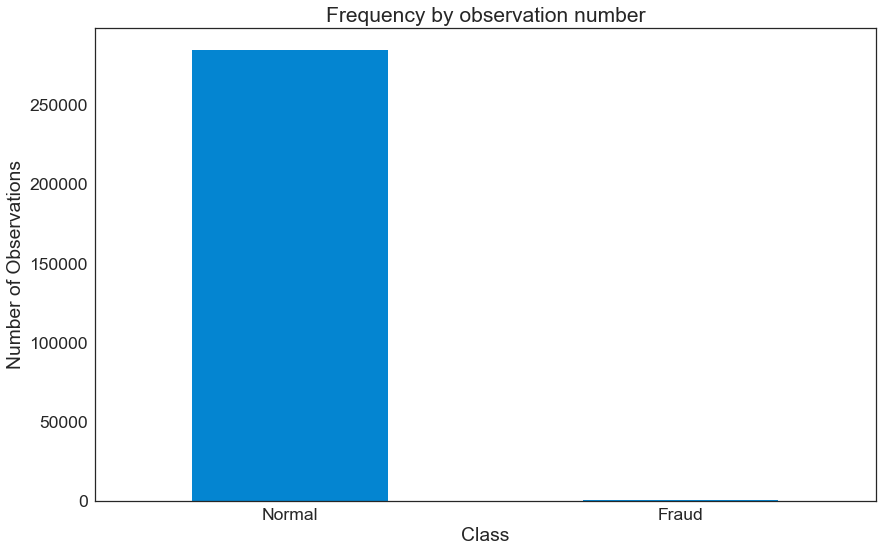

In [6]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");



As you can see, the normal cases strongly out-weigh the fraud cases.

### Summary Statistics of the Transaction Amount Data
We will cut up the data set into two data frames, one for normal transactions and the other for fraud.

In [7]:
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

Let's look at some summary statistics and see if there are obvious differences between fraud and normal transactions.

In [8]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## TODO: Describe fraud

In [9]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.  I could run statistical tests (e.g. t-test) to support the claim that the two samples likely come from populations with similar means and deviations.  However such statistical methods are not the focus of this article on autoencoders.

### Visual Exploration of the Transaction Amount Data
We are going to get more familiar with the data and try some basic visuals. In anomaly detection data sets it is common to have the areas of interest "washed out" by abundant data. The most common method is to simply 'slice and dice' the data in a couple different ways until something interesting is found.  Although this practice is common, it is **not** a scientifically sound way to explore data. There are always non-meaningful quirks to real data, so just looking until you "find something interesting" is likely going to result in you finding a false positives.  In other words, you find a random pattern in the current data set that will never be seen again.  As a [famous economist](https://www.nobelprize.org/nobel_prizes/economic-sciences/laureates/1991/coase-bio.html) wrote, ["If you torture the data long enough, it will confess"](https://www.goodreads.com/quotes/1249307-if-you-torture-the-data-long-enough-it-will-confess).

In this data set I expect a lot of low-value transactions that will be generally uninteresting (buying cups of coffee, lunches, etc).  This abundant data is likely to wash out the rest of the data, so I decided to look at the data in a number different \$100 and \$1,000 intervals.  Since it would be tedious to show reader these graphs, I will only show the final graph that only visualizes the transactions above \$200.  

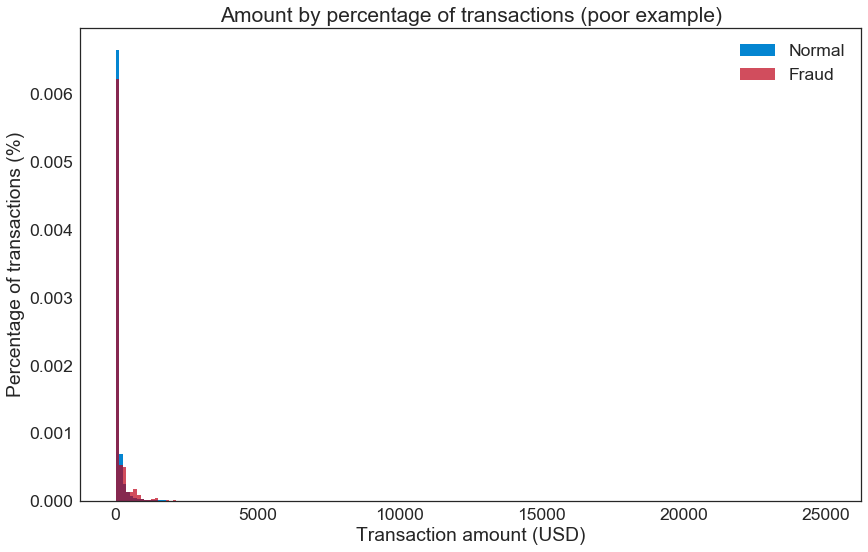

In [10]:
#Naive plot, can't really see anything
bins = np.linspace(0, 25000, 200)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.7, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (poor example)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

The above histogram is not an effective visualization because the range is too large to see anything interesting. We will cut up this data range. The first visualization will be for low value transactions (< 200) and the second for higher value transactions (> 200).

## TODO: Print the values of transactions between 0 and 200

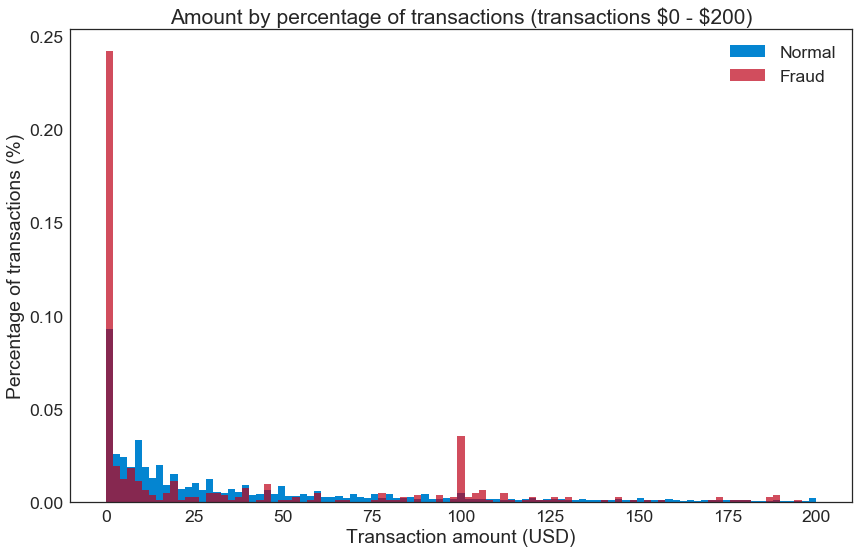

In [11]:
#plot of low value transactions from 0 to 200
bins = np.linspace(0, 200, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.7, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$0 - \$200)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

Interestingly enough, fraud transactions have a relatively high percentage of < 1 transactions and 100 transactions. What about the higher value transactions? 

## TODO: Print the values of transactions above 200

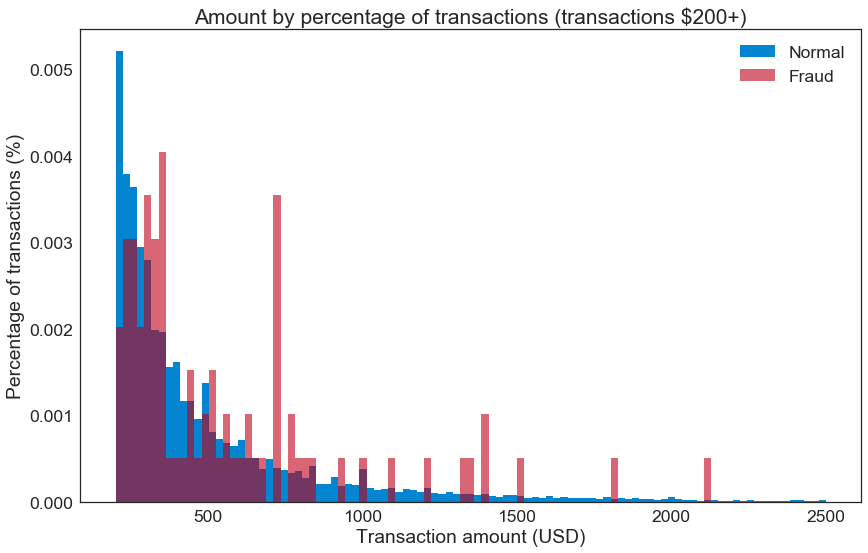

In [10]:
#TODO plot of high value transactions from 200 to 2500
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

Since the fraud cases are relatively few in number compared to bin size, we see the data looks predictably more variable.  In the long tail especially we are likely observing only a single fraud transaction.  It would be hard to differentiate fraud from normal transactions by transaction amount alone.

### Visual Exploration of the Data by Hour
With a few exceptions, the transaction amount does not look very informative.  Let's look at the time of day next.

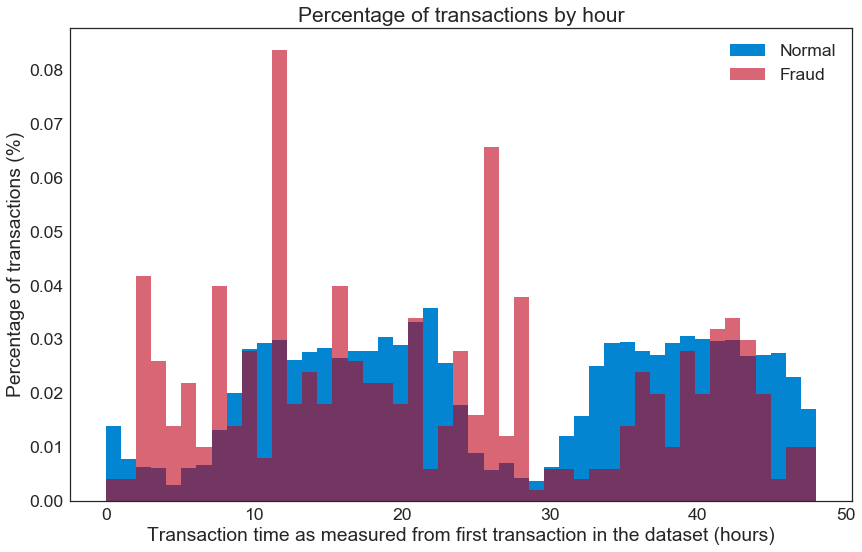

In [11]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, I am assuming those time correspond to nighttime for this data set. If this is true, fraud tends to occur at higher rates during the night. Statistical tests could be used to give evidence for this fact, but are not in the scope of this article. Again however, the potential time offset between normal and fraud transactions is not enough to make a simple, precise classifier.

Next we will explore the potential interaction between transaction amount and hour to see if any patterns emerge.

### Visual Exploration of Transaction Amount vs. Hour

## TODO: Scatter plot normal vs fraud amount vs hour

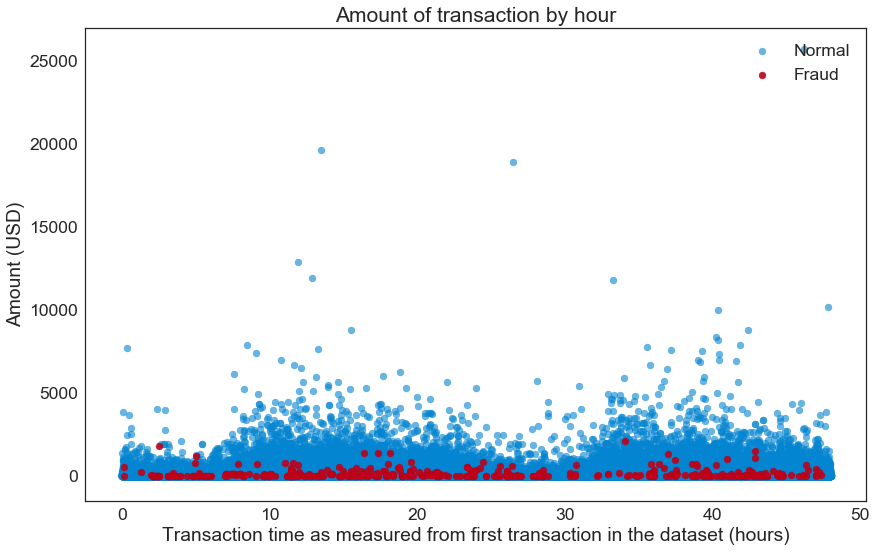

In [12]:
#TODO plot the fraud time vs normal time
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

Again, this is not enough to make a good classifier.  For example, it would be hard to draw a line that cleanly separates fraud and normal transactions.  For the experienced Data Scientists in the readership, I am excluding more advanced techniques such as the kernel trick.

## Model Setup: Basic Autoencoder
Now that more simplistic methods are not proving that useful, we are justified in exploring our autoencoder to see if it does a little better.


### Normalize and Scale Data
Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value.  It is therefore common to scale the data to similar magnitudes.  Although there are many different scaling methods and reasons to choose one method over the other, in this case I will error towards consistency.  The reader may remember that most of the data (other than 'time' and 'amount') are resultant from the product of a PCA analysis.  The PCA done on the data set transformed it into standard-normal form.  I will do the same to the 'time' and 'amount' columns.

In [13]:
#data = df.drop(['Time'], axis=1) #if you think the var is unimportant
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

### Dividing Training and Test Set
Now we split the data into training and testing sets according the percentage and with a random seed we wrote at the beginning of the code.  This should have been done before the exploratory data analysis, but for ease of explanation I delayed it until right before the model.

In [14]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values


Just confirming the new ndarray is the expected shape.

In [15]:
train_x.shape

(227468, 30)

## Creating the Model
### Autoencoder Layer Structure and Parameters
Below we set up the structure of the autoencoder. It has symmetric encoding and decoding layers that are "dense" (e.g. full connected).  The choice of the size of these layers is relatively arbitrary and generally the coder experiments with a few different layer sizes.  

Remember you are reducing the input into some form of simplified encoding and then expanding it again.  The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that I expect to represent some feature.  In this case I am encoding 30 columns into 14 dimensions so I am expecting high level features to be represented by roughly two columns (30/14 = 2.1).  Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

![Autoencoder Architecture](image/ae-arch.jpg)

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically or for reasons that can and have repeatedly filled Data Science books.  Explanation of the balancing of these values is far beyond this tutorial, but I would refer you to excellent texts such as [Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://shop.oreilly.com/product/0636920052289.do) or [Deep Learning](http://shop.oreilly.com/product/0636920035343.do).

## TODO: Complete the autoencoder

In [16]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
#TODO program the rest of the decoder
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

### Model Training and Logging
Below is where we set up the actual run including checkpoints and the tensorboard

## TODO Compile the autoencoder

In [17]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam') #TODO metrics accuracy, loss mean squared error, optimizer adam

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 4s 18us/step - loss: 0.8613 - acc: 0.4920 - val_loss: 0.8306 - val_acc: 0.6053
Epoch 2/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7807 - acc: 0.6201 - val_loss: 0.8008 - val_acc: 0.6355
Epoch 3/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7608 - acc: 0.6439 - val_loss: 0.7884 - val_acc: 0.6537
Epoch 4/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7514 - acc: 0.6550 - val_loss: 0.7793 - val_acc: 0.6609
Epoch 5/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7454 - acc: 0.6631 - val_loss: 0.7745 - val_acc: 0.6663
Epoch 6/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7411 - acc: 0.6685 - val_loss: 0.7704 - val_acc: 0.6692
Epoch 7/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7368 - acc: 0.6712 - val_

Epoch 59/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.7024 - acc: 0.7034 - val_loss: 0.7365 - val_acc: 0.7085
Epoch 60/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.7026 - acc: 0.7037 - val_loss: 0.7371 - val_acc: 0.7047
Epoch 61/100
227468/227468 [==============================] - 4s 15us/step - loss: 0.7024 - acc: 0.7042 - val_loss: 0.7358 - val_acc: 0.7081
Epoch 62/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.7022 - acc: 0.7038 - val_loss: 0.7367 - val_acc: 0.7073
Epoch 63/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.7021 - acc: 0.7035 - val_loss: 0.7369 - val_acc: 0.7060
Epoch 64/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7021 - acc: 0.7035 - val_loss: 0.7374 - val_acc: 0.7024
Epoch 65/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.7019 - acc: 0.7042 - val_loss: 0.7361 - val_acc: 0.7079
Epoch 66/100


In [18]:
autoencoder = load_model('autoencoder_fraud.h5')

## Model Evaluation
### Model Loss
The model seems to be performing well-enough, although there is significant room for improvement. This simple autooencoder architecture was chosen for ease of explanation within this tutorial. However it is my intuition that it is too simple relative to complex financial data and that overall performance could be improved by adding more hidden layers. More hidden layers would allow this network to encode more complex relationships between the input features. Please feel free to experiment with the code and let me know what you find out.

The loss of our current model seems to be converging and so more training epochs are not likely going to help. Let's explore this visually to confirm.

## TODO: Plot loss and validation loss (look in the 'history' variable)

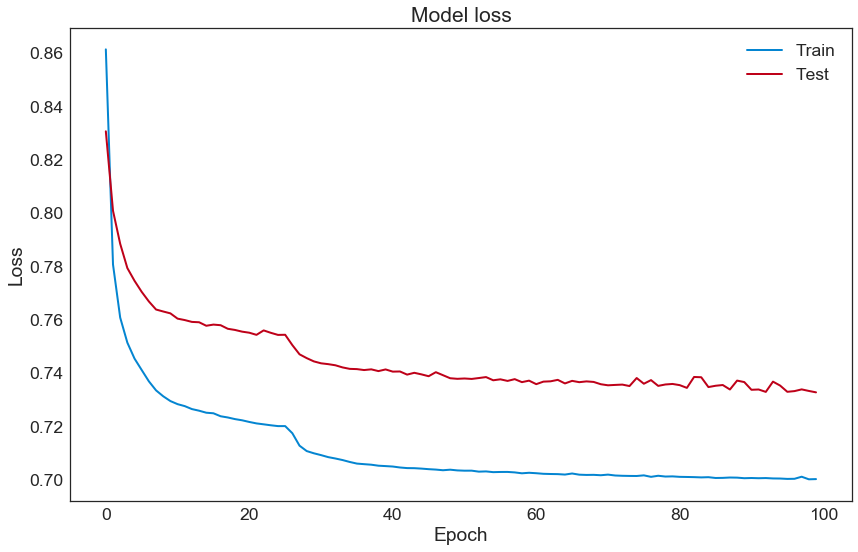

In [19]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

### Reconstruction Error Check
Autoencoders are trained to reduce reconstruction error which we show below: 

In [20]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.732606,0.002019
std,3.073105,0.044887
min,0.047161,0.000000
25%,0.250834,0.000000
50%,0.401141,0.000000
75%,0.635636,0.000000
max,189.884587,1.000000


### ROC Curve Check
Receiver operating characteristic curves are an expected output of most binary classifiers.  Since we have an imbalanced data set they are somewhat less useful.  Why? because you could generate a pretty good looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud.  Without getting into detail, this is something called the [Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox) 

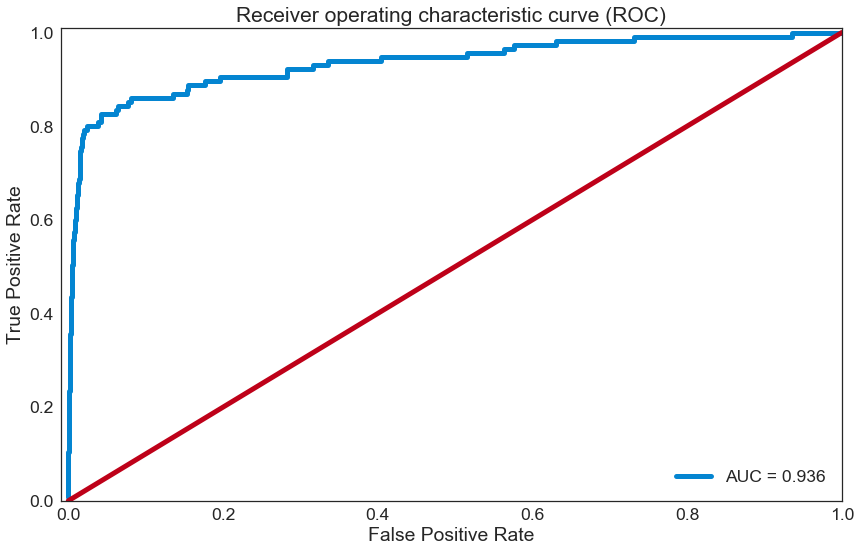

In [21]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Recall vs. Precision Thresholding
Now let's look at recall vs. precision to see the trade-off between the two

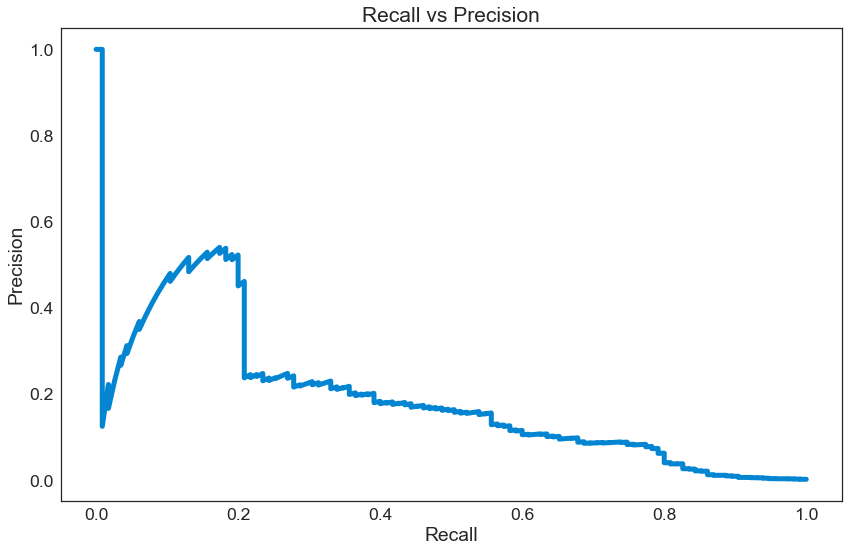

In [22]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Precision and recall are the eternal trade off in data science, so at some point you have the draw a arbitrary line, or a threshold.  Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.  Add those two weights to the calculation and you can come up with some theoretical optimal solution.  This is rarely the way it is done in practice however, as it is hard to quantify a lot of those costs (such as a customer annoyance at getting fraud alerts too frequently), or because of various structural, technical, or business rules preventing the optimized solution from be chosen.   

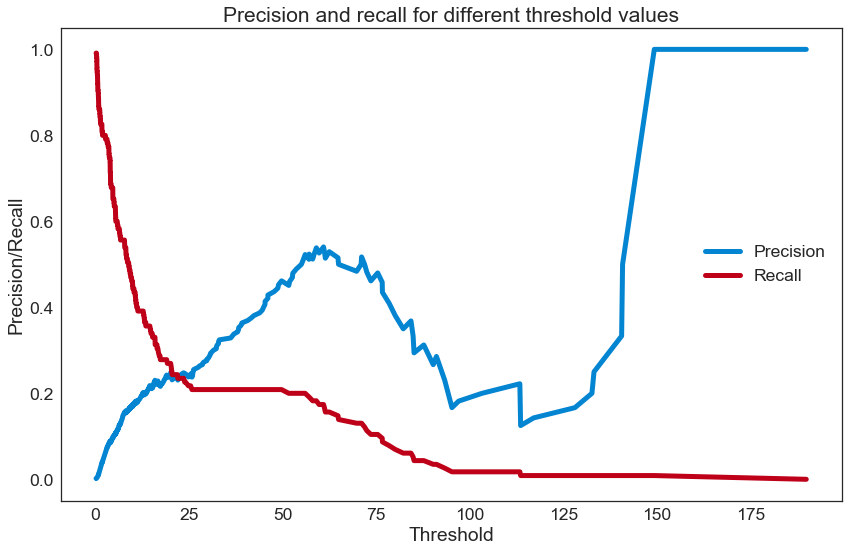

In [23]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Now that we have talked with the business client and established a threshold, let's see how that compares to reconstruction error. Where the threshold is set seems to miss the main cluster of the normal transactions, but still get a lot of the fraud transactions. 

### Reconstruction Error vs Threshold Check

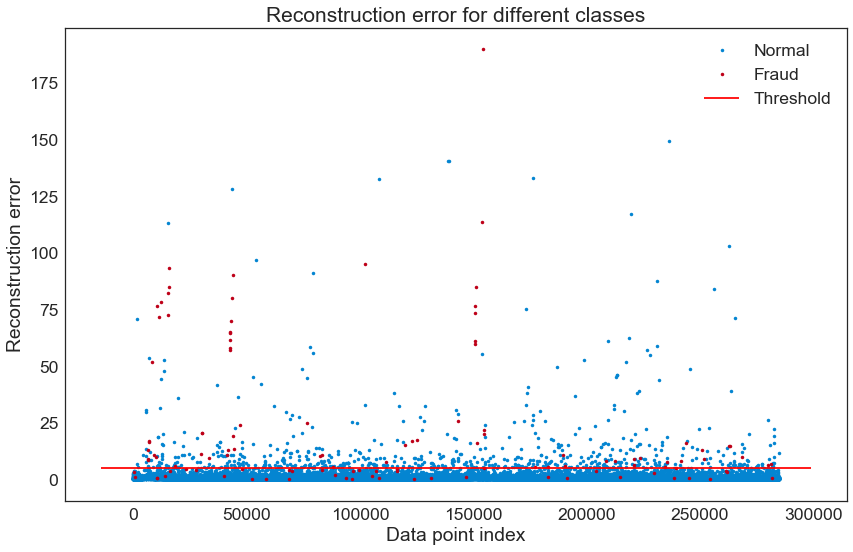

In [24]:

threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### Confusion Matrix
Finally we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set.  Here I really take a look at the ratio of detected fraud cases to false positives.  A 1:10 ratio is a fairly standard benchmark if there are not business rules or cost trade-offs that dominate that decision.  However I can assure any real-world Data Scientist that there will indeed be at least those outside influences, if not vastly more outside influences ranging from regulatory and privacy concerns to executive confidence in data and technology in general.      

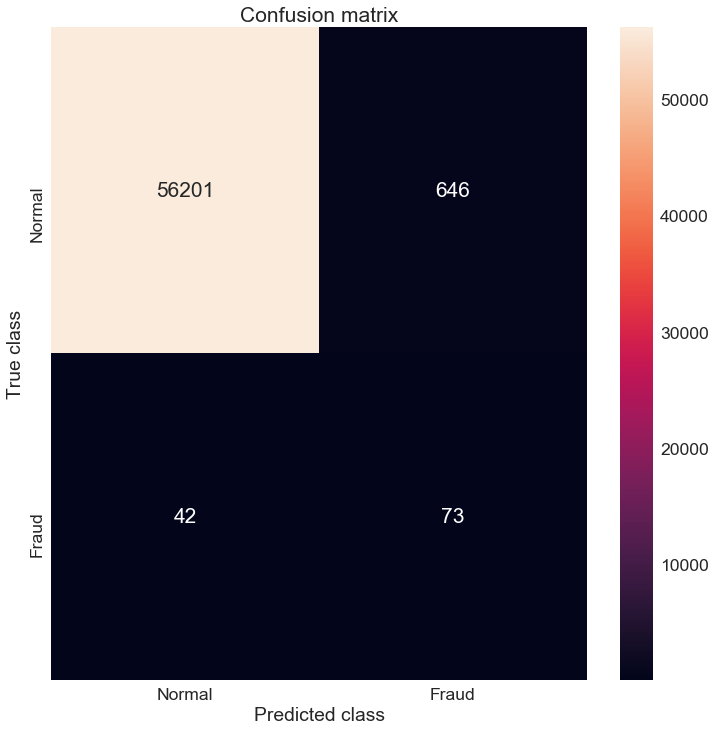

In [25]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

You will also notice we caught about 60% of the fraud cases, which might seem low at face value but remember there is no magic bullets here.  Remember two things: 1) you will never catch even close to 100% of the fraud cases in any way that is even remotely real-world useful and 2) your fraud detection algorithm will be running as a part of the overall ensemble of fraud detectors that will hopefully compliment your model.  Data science, as with so much else is life, is a team effort. With this tutorial and some real-world experience, it is my hope that the reader will be able to contribute more value to the organization or community in which they choose to operate  

## Conclusion
In this tutorial I presented the business case for card payment fraud detection and provided a brief overview of the algorithms in use.  I then used some basic exploratory data analysis techniques to show that simple linear methods would not be a good choice as a fraud detection algorithm and so chose to explore an autoencoders.  I then explained and ran a simple autoencoder written in Keras and analyzed the utility of that model.  Finally I discussed some of the business and real-world implications to choices made with the model.

## References and Credits
[Nilson Report](https://nilsonreport.com/) <br />
[Forbes Article About Credit Card Fraud Growth](https://www.forbes.com/sites/rogeraitken/2016/10/26/us-card-fraud-losses-could-exceed-12bn-by-2020/#59e00dd6d243) <br />
[Forbes List of Company Revenue](https://www.forbes.com/global2000/list/26/#header:revenue) <br />
[PayPal Using AI from American Banker](https://www.americanbanker.com/news/how-paypal-is-taking-a-chance-on-ai-to-fight-fraud) <br />
[How PayPal beats the bad guys with machine learning](https://www.infoworld.com/article/2907877/machine-learning/how-paypal-reduces-fraud-with-machine-learning.html) <br />
[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) <br />
[Calibrating Probability with Undersampling for Unbalanced Classification](https://www3.nd.edu/~rjohns15/content/papers/ssci2015_calibrating.pdf) <br />
[Wallet Hub Article with Credit Card Fraud Statistics](https://wallethub.com/edu/credit-debit-card-fraud-statistics/25725/) <br />
[Stanford Tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/) <br />
[Background Paper on Variational Autoencoders](https://arxiv.org/abs/1312.6114) <br />
[Fraud Detect Using R and H20](https://shiring.github.io/machine_learning/2017/05/01/fraud)
[Kaggle Competition Using Autoencoders in Tensorflow](https://www.kaggle.com/pgladkov/fraud-detection-using-autoencoder) <br />
[Diving Into TensorFlow With Stacked Autoencoders](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html) <br />
[A Beginner’s Guide to Deep Autoencoders](https://deeplearning4j.org/deepautoencoder) <br />
[Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://shop.oreilly.com/product/0636920052289.do) <br />
[Deep Learning](http://shop.oreilly.com/product/0636920035343.do) <br />
[Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox) <br />
[Real Bicycle Image from Wikimedia](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/BMX_bicycle.JPG/640px-BMX_bicycle.JPG) <br />
[Vector Bicycle Image from Pixabay](https://pixabay.com/en/bicycle-bike-cycling-drive-profile-2730750/) <br />


## Conflict of Interest Statement
I have no personal financial interests in the books or links discussed in this tutorial. Although if O'Reilly Media went out of business I'd be sad and if major American financial institutions should crash as a result of excessive payment card fraud then it clearly would affect me (along with a lot of other people).

## About the Author
David Ellison is the Senior Artificial Intelligence Data Scientist for Lenovo.  Through Lenovo’s US and European Innovation Centers, he uses cutting-edge AI techniques to deliver solutions for external customers while internally supporting the overall AI strategy for the World Wide Data Center Group. Currently, his emphasis is in distributed training of neural networks and fine-grain objection detection using high-resolution imaging. Previous to Lenovo, he ran an international scientific analysis and equipment company and worked as a Data Scientist for the US Postal Service. He is the author of numerous books, patents, and peer-reviewed articles published in journals such as the Proceedings of the National Academy of Sciences. David earned his PhD in Biomedical Engineering from John Hopkins University by applying machine learning and computer vision to various problems in regenerative medicine.